In [1]:
!nvidia-smi

Wed Dec 14 02:08:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# !pip install tensorflow==2.6.0
# !pip install keras==2.6
# import tensorflow as tf
# print(tf.__version__)

In [3]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.python.client import device_lib
import numpy as np 
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
import seaborn as sns
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from matplotlib.image import imread
import time
%matplotlib inline

In [4]:
# !kill -9 -1
print(tf.__version__)
# print(device_lib.list_local_devices())
running_env = "colab"
# running_env = "local"

2.9.2


In [17]:
if running_env == "colab":
  train_df = pd.read_csv('/content/drive/MyDrive/steel-defect-detection/input/train.csv')
else:
  train_df = pd.read_csv('input/train.csv')

train_df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [18]:
train_df = train_df.groupby('ImageId')['ClassId'].apply(list).reset_index()
train_df[:6]

,ImageId,ClassId
0,0002cc93b.jpg,[1]
1,0007a71bf.jpg,[3]
2,000a4bcdd.jpg,[1]
3,000f6bf48.jpg,[4]
4,0014fce06.jpg,[3]
5,0025bde0c.jpg,"[3, 4]"


In [19]:
mlb = MultiLabelBinarizer()
data = mlb.fit_transform(train_df['ClassId'])
defects_columns = []

for column in list(mlb.classes_):
  defects_columns.append("defect_"+ str(column))

onehot_encoded_classes_df = pd.DataFrame(data, columns=defects_columns)
onehot_encoded_classes_df[:6]

,defect_1,defect_2,defect_3,defect_4
0,1,0,0,0
1,0,0,1,0
2,1,0,0,0
3,0,0,0,1
4,0,0,1,0
5,0,0,1,1


In [20]:
train_df = pd.concat([train_df.drop('ClassId',axis=1), onehot_encoded_classes_df], axis=1)
train_df.head(10)

,ImageId,defect_1,defect_2,defect_3,defect_4
0,0002cc93b.jpg,1,0,0,0
1,0007a71bf.jpg,0,0,1,0
2,000a4bcdd.jpg,1,0,0,0
3,000f6bf48.jpg,0,0,0,1
4,0014fce06.jpg,0,0,1,0
5,0025bde0c.jpg,0,0,1,1
6,002af848d.jpg,0,0,0,1
7,002fc4e19.jpg,1,1,0,0
8,0030401a5.jpg,0,0,0,1
9,0046839bd.jpg,0,0,1,0


In [21]:
train_df.sum()

ImageId     0002cc93b.jpg0007a71bf.jpg000a4bcdd.jpg000f6bf...
defect_1                                                  897
defect_2                                                  247
defect_3                                                 5150
defect_4                                                  801
dtype: object

In [22]:
print(train_df['defect_1'].value_counts())
print(train_df['defect_2'].value_counts())
print(train_df['defect_3'].value_counts())
print(train_df['defect_4'].value_counts())

0    5769
1     897
Name: defect_1, dtype: int64
0    6419
1     247
Name: defect_2, dtype: int64
1    5150
0    1516
Name: defect_3, dtype: int64
0    5865
1     801
Name: defect_4, dtype: int64


In [23]:
if running_env == "colab":
    data_dir = '/content/drive/MyDrive/steel-defect-detection/'
else:
    data_dir = ''

test_path = data_dir + 'input/test_images'
train_path = data_dir + 'input/train_images'

In [24]:
from tensorflow.keras.models import load_model
model = load_model(data_dir+'model/inceptionv3.h5')

In [25]:
steel_image = train_path + '/' + os.listdir(train_path)[0]
imread(steel_image).shape

(256, 1600, 3)

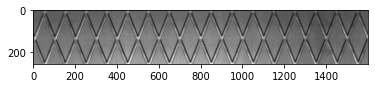

In [26]:
plt.imshow(imread(steel_image))

In [27]:
image_shape = imread(steel_image).shape
IMAGE_SIZE = list(image_shape)

In [28]:
train_df_permutated = train_df.sample(frac=1)
batch_size = 128
train_size = 0.8
validation_size = 0.1
test_size = 0.1
train_end = int(len(train_df_permutated) * train_size)
validation_end = int(len(train_df_permutated) * (train_size + validation_size))
df_train = train_df_permutated[:train_end]
df_validation = train_df_permutated[train_end: validation_end]
df_test = train_df_permutated[validation_end:]

x_column = list(df_train.columns)[0]
y_columns = list(df_train.columns)[1:]
train_datagen = ImageDataGenerator(rescale=1./255.)
validation_datagen = ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_dataframe(
                  dataframe=df_train,
                  directory=train_path,
                  x_col=x_column,
                  y_col=y_columns,
                  batch_size=batch_size,
                  seed=42,
                  shuffle=True,
                  class_mode="raw",
                  target_size=image_shape[:-1])

validation_generator = validation_datagen.flow_from_dataframe(
                dataframe=df_validation,
                directory=train_path,
                x_col=x_column,
                y_col=y_columns,
                batch_size=batch_size,
                seed=42,
                shuffle=True,
                class_mode="raw",
                target_size=image_shape[:-1])

test_generator = test_datagen.flow_from_dataframe(
                  dataframe=df_test,
                  directory=train_path,
                  x_col=x_column,
                  batch_size=batch_size,
                  seed=42,
                  shuffle=False,
                  class_mode=None,
                  target_size=image_shape[:-1])

Found 5332 validated image filenames.
Found 667 validated image filenames.
Found 667 validated image filenames.


In [29]:
steps_per_epoch = df_train.shape[0] / batch_size
validation_steps = df_validation.shape[0] / batch_size

In [ ]:
# X, y = next(train_generator)
# print(X.shape, y.shape)
# X = next(test_generator)
# print(X.shape)

In [ ]:
# inceptionv3 = InceptionV3(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)

# for layer in inceptionv3.layers:
#     layer.trainable = False

In [ ]:
# inception_op = Flatten()(inceptionv3.output)
# prediction = Dense(4, activation='sigmoid')(inception_op)

# model = Model(inputs=inceptionv3.input, outputs=prediction)
# model.summary()

In [ ]:
inceptionv4 = InceptionResNetV2(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)

for layer in inceptionv4.layers:
    layer.trainable = False

219070464/219055592 [==============================] - 4s 0us/step


In [ ]:
inception_op = Flatten()(inceptionv4.output)
prediction = Dense(4, activation='sigmoid')(inception_op)

model = Model(inputs=inceptionv4.input, outputs=prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 1600,   0           []                               
                                3)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 127, 799, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 799, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC( name='auc', multi_label=True)])

In [ ]:
# early_stop = EarlyStopping(monitor='auc', patience=10, verbose=1, mode='max')
# trained_model = model.fit_generator(generator=train_generator,
#                                     steps_per_epoch=steps_per_epoch,
#                                     validation_data=validation_generator,
#                                     validation_steps=validation_steps,
#                                     epochs=100,
#                                     callbacks = [early_stop],
#                                     verbose=1)

trained_model = model.fit_generator(generator=train_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    validation_data=validation_generator,
                                    validation_steps=validation_steps,
                                    epochs=8,
                                    verbose=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


Epoch 1/8
41/41 [==============================] - 624s 14s/step - loss: 3.4560 - auc: 0.7310 - val_loss: 0.9681 - val_auc: 0.8879
Epoch 2/8
41/41 [==============================] - 546s 13s/step - loss: 0.3150 - auc: 0.9390 - val_loss: 0.4791 - val_auc: 0.8792
Epoch 3/8
41/41 [==============================] - 546s 13s/step - loss: 0.0797 - auc: 0.9845 - val_loss: 0.5377 - val_auc: 0.9107
Epoch 4/8
41/41 [==============================] - 544s 13s/step - loss: 0.0727 - auc: 0.9845 - val_loss: 0.5262 - val_auc: 0.9050
Epoch 5/8
41/41 [==============================] - 546s 13s/step - loss: 0.0557 - auc: 0.9894 - val_loss: 0.5002 - val_auc: 0.8966
Epoch 6/8
41/41 [==============================] - 546s 13s/step - loss: 0.0294 - auc: 0.9972 - val_loss: 0.5047 - val_auc: 0.8844
Epoch 7/8
41/41 [==============================] - 546s 13s/step - loss: 0.0085 - auc: 0.9995 - val_loss: 0.4748 - val_auc: 0.9039
Epoch 8/8
41/41 [==============================] - 546s 13s/step - loss: 0.0058 - a

In [ ]:
from tensorflow.keras.models import load_model
model = load_model(data_dir+'model/inceptionv3.h5')
# model = load_model(data_dir+'model/inceptionv4.h5')
# model.save(data_dir+'model/inceptionv4.h5')

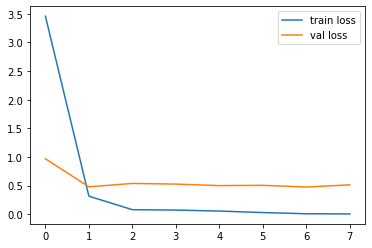

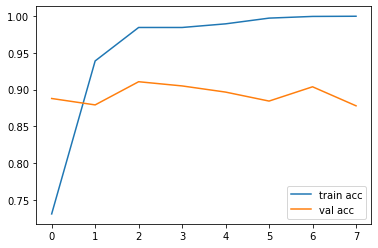

In [ ]:
# plot the loss
plt.plot(trained_model.history['loss'], label='train loss')
plt.plot(trained_model.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(trained_model.history['auc'], label='train acc')
plt.plot(trained_model.history['val_auc'], label='val acc')
plt.legend()
plt.show()

In [ ]:
print(model.evaluate_generator(test_generator))
print(model.metrics_names)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[0.0, 0.0]
['loss', 'auc']


In [30]:
pred = model.predict_generator(test_generator)

<ipython-input-30-f79076686fd5>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(test_generator)


In [31]:
np.unique(np.rint(pred).astype(int))

array([0, 1])

In [32]:
pred

array([[0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 2.2707181e-13],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [9.9986374e-01, 0.0000000e+00, 1.0000000e+00, 1.2360686e-32],
       ...,
       [5.4727254e-28, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 5.4067502e-31],
       [1.0000000e+00, 0.0000000e+00, 6.0112211e-24, 0.0000000e+00]],
      dtype=float32)

In [33]:
from sklearn.metrics import roc_auc_score, roc_curve
from numpy import sqrt, argmax

y_true = df_test[y_columns].to_numpy()
best_thresholds = []

for selectedLabel in range(len(list(df_test[y_columns].columns))):
  print("for label: {}".format(selectedLabel))
  fpr, tpr, thresholds = roc_curve(y_true[:,selectedLabel], pred[:,selectedLabel])
  gmeans = sqrt(tpr * (1-fpr))
  ix = argmax(gmeans)
  best_thresholds.append(f'{thresholds[ix]:.20f}')

print("best_thresholds: ", best_thresholds)
best_thresholds = [0.99999988079071044922, 0.00000000000000000679, 0.62790417671203613281, 0.00000000000169181238]
print("best_thresholds: ", best_thresholds)

for label: 0
for label: 1
for label: 2
for label: 3
best_thresholds:  ['0.96532827615737915039', '0.00000000000888689382', '0.60498917102813720703', '0.00000005321221863142']
best_thresholds:  [0.9999998807907104, 6.79e-18, 0.6279041767120361, 1.69181238e-12]


In [34]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix

pred_df = pd.DataFrame(pred)

for index in range(len(best_thresholds)):
  pred_df.iloc[pred_df[index] >= best_thresholds[index], index] = 1
  pred_df.iloc[pred_df[index] < best_thresholds[index], index] = 0

y_pred = pred_df.to_numpy()
print(multilabel_confusion_matrix(y_true, y_pred))
label_names = list(df_test[y_columns].columns)
print(classification_report(y_true, y_pred, target_names=label_names))

[[[561  18]
  [  2  86]]

 [[639   2]
  [  1  25]]

 [[141  10]
  [ 11 505]]

 [[573  12]
  [  2  80]]]
              precision    recall  f1-score   support

    defect_1       0.83      0.98      0.90        88
    defect_2       0.93      0.96      0.94        26
    defect_3       0.98      0.98      0.98       516
    defect_4       0.87      0.98      0.92        82

   micro avg       0.94      0.98      0.96       712
   macro avg       0.90      0.97      0.93       712
weighted avg       0.95      0.98      0.96       712
 samples avg       0.96      0.98      0.96       712



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
from sklearn import metrics

print("micro: {:.2f}".format(metrics.precision_score(y_true, y_pred, average='micro')))
print("macro: {:.2f} ".format( metrics.precision_score(y_true, y_pred, average='macro')))
print("weighted: {:.2f} ".format( metrics.precision_score(y_true, y_pred, average='weighted')))
print("for each category: {} ".format( metrics.precision_score(y_true, y_pred, average=None)))

micro: 0.94
macro: 0.90 
weighted: 0.95 
for each category: [0.82692308 0.92592593 0.98058252 0.86956522] 


In [36]:
y_true

array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       ...,
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0]])

In [37]:
y_pred

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [64]:
print(train_df.query('ImageId	=="248585a26.jpg"'))
image_shape = (256, 1600, 3)

my_image = image.load_img(train_path+'/248585a26.jpg', target_size=image_shape)
my_img_arr = image.img_to_array(my_image)
my_img_arr  = my_img_arr/255. 
my_img_arr = my_img_arr.reshape((1,) + image_shape)
model_pred = model.predict(my_img_arr)

model_pred_df = pd.DataFrame(model_pred)

for index in range(len(best_thresholds)):
  model_pred_df.iloc[model_pred_df[index] >= best_thresholds[index], index] = 1
  model_pred_df.iloc[model_pred_df[index] < best_thresholds[index], index] = 0

model_pred_df.to_numpy()

           ImageId  defect_1  defect_2  defect_3  defect_4
955  248585a26.jpg         0         0         1         1
1/1 [==============================] - 0s 125ms/step


array([[0., 0., 1., 1.]], dtype=float32)